## 'Dogs vs Cats'

Can a neural net tell the difference between my pets, and the pets of other people who I at some point ended up with a picture of? We'll see!

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Just import everything
from fastai.imports import *

/home/matt/.conda/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [6]:
PATH = "data/dogscats/"
sz=224    #I don't actually know what this number means yet

## Here's a cat

Our library will assume that you have *train* and *valid* directories. It also assumes that each dir will have subdirs for each class you wish to recognize (in this case, 'cats' and 'dogs').

In [7]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['11.jpg', '13.jpg', '12.jpg', '14.jpg', '2.jpg']

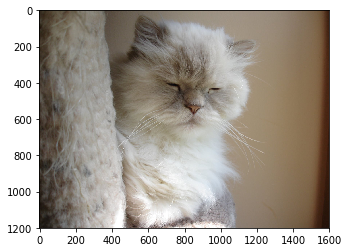

In [10]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

## Here's a dog

In [13]:
files2 = os.listdir(f'{PATH}valid/dogs')[:5]
files

['11.jpg', '13.jpg', '12.jpg', '14.jpg', '2.jpg']

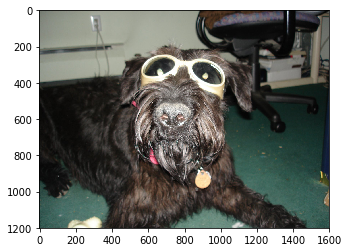

In [14]:
img = plt.imread(f'{PATH}valid/dogs/{files2[0]}')
plt.imshow(img);

## Train the model

In [15]:
# Uncomment the below if you need to reset your precomputed activations
#shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [32]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 5)

epoch      trn_loss   val_loss   accuracy                     
    0      0.050137   0.215091   0.909091  
    1      0.048467   0.111897   0.909091                     
    2      0.035289   0.307785   0.818182                     
    3      0.041056   0.300773   0.909091                     
    4      0.032061   0.304096   0.909091                     



[array([0.3041]), 0.9090909361839294]

## Analyzing results

In [17]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(11, 2)

In [37]:
log_preds[:10]

array([[ -0.00006,  -9.70939],
       [ -0.00003, -10.47305],
       [ -0.     , -12.4602 ],
       [  0.     , -15.35235],
       [ -0.00005,  -9.93867],
       [ -6.87408,  -0.00103],
       [-10.29577,  -0.00003],
       [ -5.97977,  -0.00253],
       [ -0.08602,  -2.49587],
       [ -0.0261 ,  -3.65878]], dtype=float32)

In [18]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [19]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [20]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [21]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


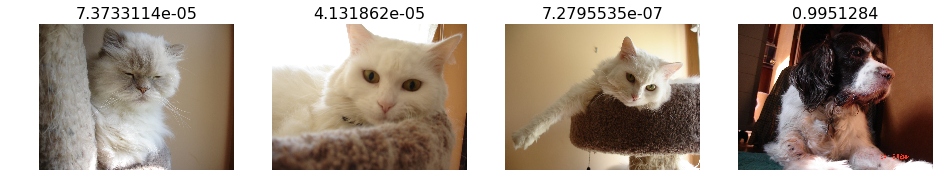

In [22]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [24]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


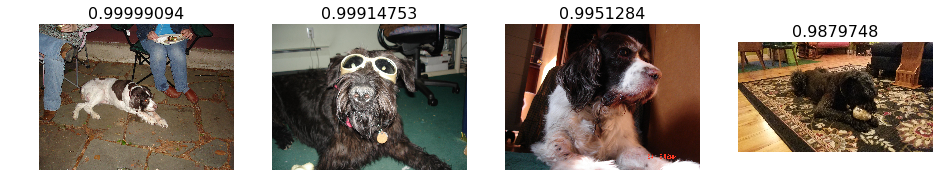

In [25]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

In [26]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect cats
Not Found.


Most incorrect dogs


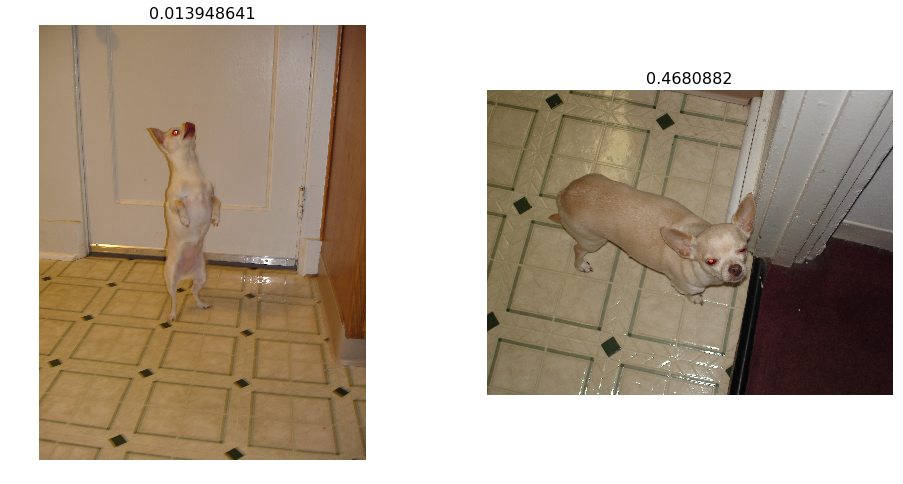

In [27]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


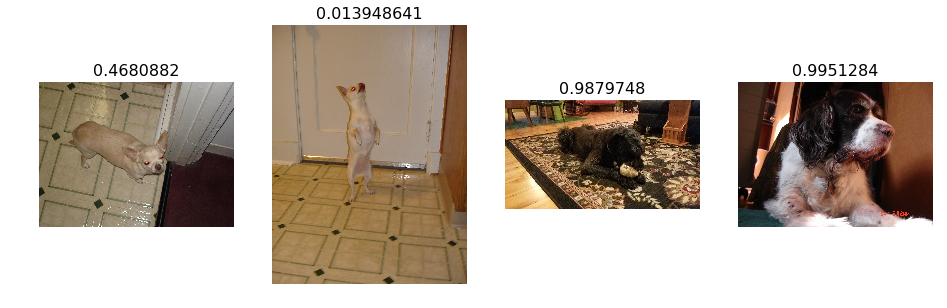

In [28]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Summary

This was basically all about just swapping in my own dogs and cats for the sample image set.  Even with this tiny image set, things went pretty well.

The ugly chihuahua isn't mine.

## Comments

@DougS: My daughter's favorite dog is a chihuahua. I have no idea why, small yippie little beasts. You dog is hip, I give the work high marks even if I cannot buy drugs legally in Burlington yet.